In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from statsmodels.tsa.ar_model import AutoReg

In [2]:
raw_learn = pd.read_csv('../data/processed/learn.csv')
raw_test = pd.read_csv('../data/processed/test.csv')

raw = pd.read_excel('../data/raw/kadai.xlsx')

In [3]:
raw_learn.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [4]:
"""def drop_final_mes_time(df):
    df = df.drop(columns=['final_mes_time'])
    return df

raw_learn = drop_final_mes_time(raw_learn)
raw_test = drop_final_mes_time(raw_test)
raw = drop_final_mes_time(raw)"""

"def drop_final_mes_time(df):\n    df = df.drop(columns=['final_mes_time'])\n    return df\n\nraw_learn = drop_final_mes_time(raw_learn)\nraw_test = drop_final_mes_time(raw_test)\nraw = drop_final_mes_time(raw)"

In [5]:
def df_set_datetime(df, col_name):
    for col in col_name:
        df[col] = pd.to_datetime(df[col])
    return df

raw_learn = df_set_datetime(raw_learn, ["process_end_time", "final_mes_time"])
raw_test = df_set_datetime(raw_test, ["process_end_time", "final_mes_time"])
raw = df_set_datetime(raw, ["process_end_time", "final_mes_time"])

In [6]:
# process_end_timeを用いて経過時間, ラグを取得する。

def get_elapsed_day(df, base_time=None):
    if base_time == None:
        base_time = df['process_end_time'].min()
    df['elapsed_day'] = (df['process_end_time'] - base_time).dt.days
    return df

raw_learn = get_elapsed_day(raw_learn)
raw_test = get_elapsed_day(raw_test)
raw = get_elapsed_day(raw)

In [7]:
def set_LagOV(df,target="OV", lag_record_num=1, window=3):
    df[f"{target}_lag{lag_record_num}"] = df[target].shift(lag_record_num)
    df[f"{target}_diff"] = df[target].diff(1).shift(1)  
    df[f"{target}_roll_mean{window}"] = df[target].rolling(window).mean().shift(1)
    df[f"{target}_roll_std{window}"] = df[target].rolling(window).std().shift(1)
    df = df.dropna().reset_index(drop=True)
    return df

raw_learn = set_LagOV(raw_learn)
raw_test = set_LagOV(raw_test)
raw = set_LagOV(raw)

In [8]:
raw_learn.head(5)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X79,X80,X81,X82,X83,elapsed_day,OV_lag1,OV_diff,OV_roll_mean3,OV_roll_std3
0,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,111.9410,-89.6207,141.597100,51.931891
1,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,182.3914,70.4504,165.298033,47.192212
2,2016-08-14 23:07:00,2016-09-24 21:35:00,240.5799,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,196.2703,13.8789,163.534233,45.216725
3,2016-08-14 23:07:00,2016-09-24 22:32:00,105.9398,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,240.5799,44.3096,206.413867,30.391518
4,2016-08-14 23:07:00,2016-09-25 01:47:00,169.5418,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,4.1,0.0,0.01,0.16,0.04,0,105.9398,-134.6401,180.930000,68.618385


In [9]:
raw.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X79,X80,X81,X82,X83,elapsed_day,OV_lag1,OV_diff,OV_roll_mean3,OV_roll_std3
0,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,111.9410,-89.6207,141.597100,51.931891
1,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,4.1,0.0,0.01,0.16,0.04,0,182.3914,70.4504,165.298033,47.192212
2,2016-08-14 23:07:00,2016-09-24 21:35:00,240.5799,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,196.2703,13.8789,163.534233,45.216725
3,2016-08-14 23:07:00,2016-09-24 22:32:00,105.9398,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,4.1,0.0,0.01,0.16,0.04,0,240.5799,44.3096,206.413867,30.391518
4,2016-08-14 23:07:00,2016-09-25 01:47:00,169.5418,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,4.1,0.0,0.01,0.16,0.04,0,105.9398,-134.6401,180.930000,68.618385


In [14]:
raw.shape[0]

2273

 99%|█████████▉| 497/500 [02:36<00:00,  3.17it/s]


RMSE): 7.438958973738584


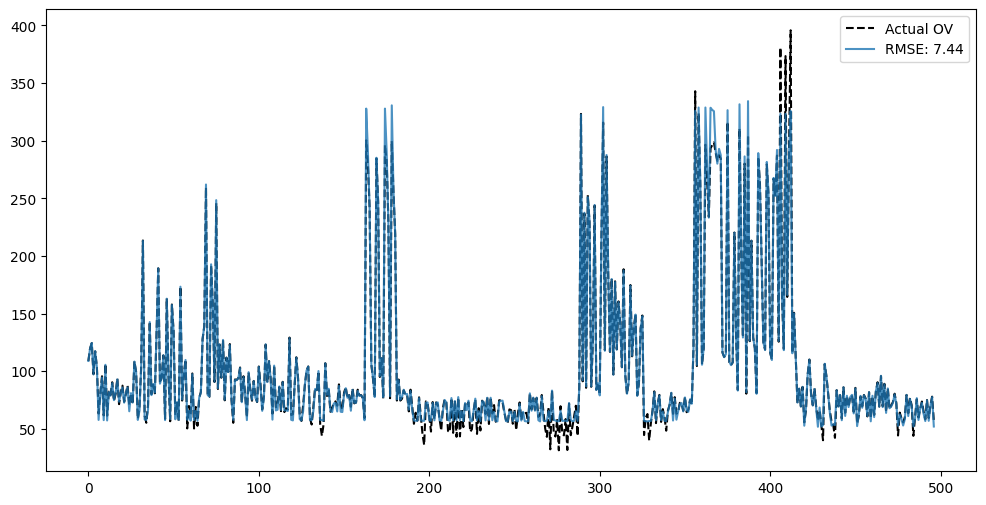

In [16]:
# 使用する特徴量カラム名をリストではなく単純なリストで指定
feature_cols = ["X14", "X30", "X33", "X83", "OV", "elapsed_day", "OV_lag1", "OV_diff", "OV_roll_mean3", "OV_roll_std3"]
yHat = []

scoring = "neg_root_mean_squared_error"

# 1レコードずつtestにしてループ
for i in tqdm.tqdm(range(1776, 2276)):
    learn = raw[0:i]
    test = raw[i:i+2]
    # インデックスをリセットする
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)
    if test.empty:
      break
    test_process_end_time = test['process_end_time'].iloc[0]
    #print(test_process_end_time)
    learn = learn[learn["final_mes_time"] < test_process_end_time]
    # 説明変数と目的変数に分離
    # 学習データ
    X_l = learn[feature_cols]
    Y_l = learn.OV
    # テストデータ
    X_t = test[feature_cols]
    Y_t = test.OV

    # モデリング
    pipeline = Pipeline([
        #("selector", SelectFromModel()),
        ("StandardScaler", StandardScaler()),
        ("model_LGBM", LGBMRegressor(
            objective="regression",
            metric="rmse",
            verbose=-1,
            random_state=42
        ))
    ])
    pipeline.fit(X_l, Y_l)
    pred = pipeline.predict(X_t)
    yHat.append(pred[0])  # 予測値を格納（1レコードなので[0]）

# Y_tは予測値と同じ個数だけ取得する
Y_t = raw["OV"][1776:(1776 + len(yHat))].reset_index(drop=True).values
plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
yh = np.array(yHat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'RMSE: {rmse:.2f}', alpha=0.8)
print(f"RMSE): {rmse}")
plt.legend()
plt.show()